In [1]:
import sparsedm
import numpy as np
import matplotlib.pyplot as plt
import circuit
%matplotlib inline

### Create circuit

In [2]:
qubit_names = ["D1", "A1", "D2", "A2", "D3"]

In [3]:
# calculate the ancilla t2 by taking into account photons on average

import qec.backend.single_qubit_photons as single_qubit_photons

pg1, pe1, pg2, pe2 = single_qubit_photons.photon_noise(t_rest=1000)

#decay_prob_ancilla = 0.5*(pe1*pe2)**2 + 0.5*(pg1*pg2)**2
decay_prob_ancilla = 1-(pe1*pe2)**2 

In [4]:
decay_prob_ancilla

0.004706914922025018

In [5]:
t_meas = 300
t_rest = 1000
t_gate = 40

t1 = 25000
t2 = 16000

t2_ancilla = 1/(1/(4*t_gate/(decay_prob_ancilla)) + 1/t2)
t2_ancilla = t2


readout_error = 0.0015

In [6]:
160/t2_ancilla, 160/t2

(0.01, 0.01)

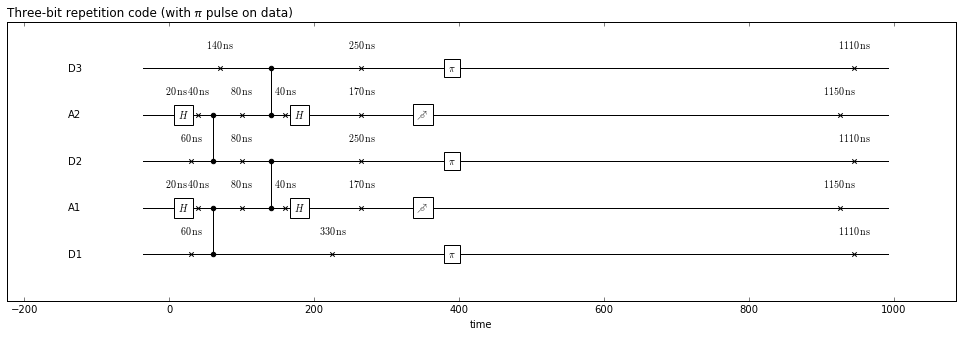

In [13]:
c = circuit.Circuit("Three-bit repetition code (with π pulse on data)")

for qb in qubit_names:
    if "A" in qb:
        c.add_qubit(qb, t1, t2_ancilla)
    else:
        c.add_qubit(qb, t1, t2)


    
c.add_hadamard("A1", time=0.5*t_gate)
c.add_hadamard("A2", time=0.5*t_gate)

c.add_cphase("A1", "D1", time=1.5*t_gate)
c.add_cphase("A2", "D2", time=1.5*t_gate)

c.add_cphase("A1", "D2", time=3.5*t_gate)
c.add_cphase("A2", "D3", time=3.5*t_gate)

c.add_hadamard("A1", time=4.5*t_gate)
c.add_hadamard("A2", time=4.5*t_gate)


sampler = circuit.uniform_noisy_sampler(seed=42, readout_error=readout_error)
m1 = circuit.Measurement("A1", time=5*t_gate+0.5*t_meas, sampler=sampler)
c.add_gate(m1)
sampler2 = circuit.uniform_noisy_sampler(seed=43, readout_error=readout_error)
m2 = circuit.Measurement("A2", time=5*t_gate+0.5*t_meas, sampler=sampler2)
c.add_gate(m2)

for qb in ['D1', 'D2', 'D3']:
    c.add_rotate_y(qb, angle=np.pi, time=5*t_gate+0.5*t_meas+t_gate)
    pass


c.add_waiting_gates(tmin=0, tmax=5*t_gate+t_meas+t_rest)

plt.figure(figsize=(17,5))


c.order()
c.plot()


repetition_code_round = c

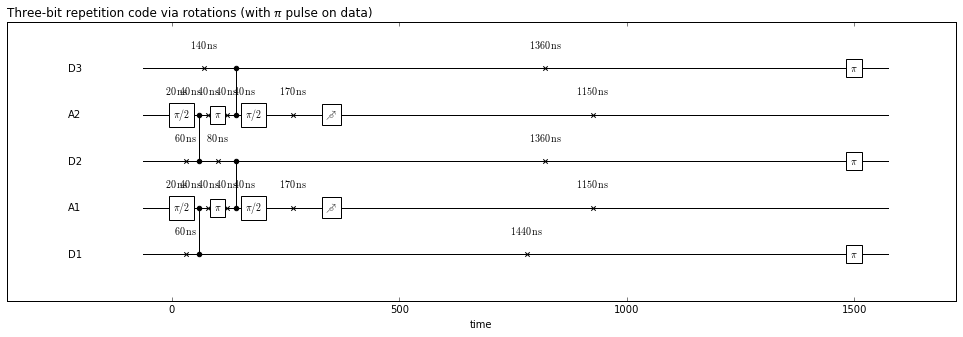

In [8]:
c = circuit.Circuit("Three-bit repetition code via rotations (with π pulse on data)")

for qb in qubit_names:
    if "A" in qb:
        c.add_qubit(qb, t1, t2_ancilla)
    else:
        c.add_qubit(qb, t1, t2)
    


c.add_rotate_y("A1", angle=np.pi/2, time=0.5*t_gate)
c.add_rotate_y("A2", angle=np.pi/2, time=0.5*t_gate)

c.add_cphase("A1", "D1", time=1.5*t_gate)
c.add_cphase("A2", "D2", time=1.5*t_gate)

c.add_rotate_y("A1", angle=np.pi, time=2.5*t_gate)
c.add_rotate_y("A2", angle=np.pi, time=2.5*t_gate)

c.add_cphase("A1", "D2", time=3.5*t_gate)
c.add_cphase("A2", "D3", time=3.5*t_gate)

c.add_rotate_y("A1", angle=np.pi/2, time=4.5*t_gate)
c.add_rotate_y("A2", angle=np.pi/2, time=4.5*t_gate)



sampler = circuit.uniform_noisy_sampler(seed=42, readout_error=readout_error)
m1 = circuit.Measurement("A1", time=5*t_gate+0.5*t_meas, sampler=sampler)
c.add_gate(m1)
sampler2 = circuit.uniform_noisy_sampler(seed=43, readout_error=readout_error)
m2 = circuit.Measurement("A2", time=5*t_gate+0.5*t_meas, sampler=sampler2)
c.add_gate(m2)

for qb in ['D1', 'D2', 'D3']:
    c.add_rotate_y(qb, angle=np.pi, time=5*t_gate+t_meas+t_rest)
    pass


c.add_waiting_gates(tmin=0, tmax=5*t_gate+t_meas+t_rest)

plt.figure(figsize=(17,5))


c.order()
c.plot()


repetition_code_round_rot = c

### A few more gates

In [ ]:
c = circuit.Circuit("Logical Hadamard gate")

for qb in qubit_names:
    c.add_qubit(qb, t1, t2)

c.add_hadamard("D1", 0)
c.add_hadamard("D2", 0)

c.add_cphase("D1", "D3", 2)
c.add_cphase("D2", "D3", 1)


c.add_hadamard("D1", 4)
c.add_hadamard("D2", 4)
c.add_hadamard("D3", 0)




c.order()
c.plot()

logical_hadamard = c

plt.figure()

c = circuit.Circuit("Data qubit measurement")

for qb in qubit_names:
    c.add_qubit(qb, t1, t2)


c.add_measurement("D1", 0, sampler=None)
c.add_measurement("D2", 0, sampler=None)
c.add_measurement("D3", 0, sampler=None)


c.order()
c.plot()

final_meas_circuit = c


### Import Toms error model and decoder

In [9]:
import qec
import qec.circuit_characterization.error_model.unsymmetrised_decay as err_model
import qec.circuit_characterization.circuit_model.three_qbit_realistic_kraus as circuit_model
import qec.error_correction.correction_method.asym_de_rep as correction

tom_error = err_model.Error(T1=t1, ro=readout_error, t_rest=t_rest, Tphi=t2) 
tom_circuit = circuit_model.Circuit(tom_error, t_rest, t_gate, t_meas)



tom_decoder = correction.Correction(tom_circuit)

### Do 1000 runs of 20 rounds of correction

We initialize the data qubits in either all up or down, and the ancillas randomly in up or down. Then run the 
correction after each round, and see whether the measurement, after application of the correction, is the initial state 
with at most one bit flipped (majority vote) for even round numbers, or the opposite state for odd round numbers (the circuit flips the data qubits after each round.

In [14]:
rounds = 20

fidelity_list = [[] for _ in range(rounds)]
fidelity_list_no_correction = [[] for _ in range(rounds)]

no_repetitions = 3000

for _ in range(no_repetitions):
    sdm = sparsedm.SparseDM(qubit_names)

    sdm.classical['A1'] = np.random.randint(2)
    sdm.classical['A2'] = np.random.randint(2)

    sdm.classical['D1'] = np.random.randint(2)
    sdm.classical['D2'] = sdm.classical['D1']
    sdm.classical['D3'] = sdm.classical['D1']

    tom_circuit.m2 = sdm.classical['A1']
    tom_circuit.m4 = sdm.classical['A2'] 
    tom_decoder.reset()

    init_state = sdm.classical['D1']
    for i in range(rounds):
        repetition_code_round.apply_to(sdm)
        sdm.renormalize()
        syndrome = [m1.measurements[-1], m2.measurements[-1]]
        tom_decoder.update(syndrome)
        
        correction = tom_decoder.result()
        #correction = [0, 0, 0]
        actual_states = sdm.peak_multiple_measurements(['D1', 'D2', 'D3'])

        fidelity = 0.0
        fidelity_no_correction = 0.0
        for state, prob in actual_states:
            final = [(state['D1'] + correction[0]) % 2, 
                    (state['D2'] + correction[1]) % 2, 
                    (state['D3'] + correction[2]) % 2, ]
            majority_vote = int(sum(final) >= 2)
            if majority_vote == (init_state + i + 1) % 2:
                fidelity += prob
            
            final = [(state['D1']) % 2, 
                    (state['D2']) % 2, 
                    (state['D3']) % 2, ]
            majority_vote = int(sum(final) >= 2)
            if majority_vote == (init_state + i + 1) % 2:
                fidelity_no_correction += prob                
                
            #if all(s == (init_state + i + 1)%2 for s in final):
                #fidelity += prob

        fidelity_list[i].append(fidelity)
        fidelity_list_no_correction[i].append(fidelity_no_correction)
    
    
me_fide_c_flip = np.array(fidelity_list).mean(1)
me_fide_c_error = np.array(fidelity_list).std(1)/np.sqrt(no_repetitions)
me_fide_nc_flip = np.array(fidelity_list_no_correction).mean(1)
me_fide_nc_error = np.array(fidelity_list_no_correction).std(1)/np.sqrt(no_repetitions)

### Run Toms code for comparison

In [11]:
import qec.scripts.three_qubit_rep_fidelity as toms

toms_fide, toms_fide_no_correction = toms.run(num_repetitions=3000, flipping=True)

### Plot the results 

/home/brianzi/env3/lib/python3.6/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


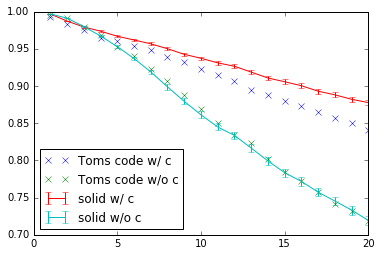

In [15]:


# 
p = np.exp(-(t_rest+5*t_gate+t_meas)/t1)

#plt.plot(range(1, 20+1), 
#        [1-(3*(1-p**n)**2*(p**n)+(1-p**n)**3)/2 for n in range(1, 20+1)])

n = np.arange(1, 21)

plt.plot(n, toms_fide, "x", label='Toms code w/ c')
plt.plot(n, toms_fide_no_correction, "x", label='Toms code w/o c')

#plt.errorbar(n, 1-(1-me_fide_c_flip)*1.2 , yerr=me_fide_c_error, label='solid w/ c * 1.5')
plt.errorbar(n, me_fide_c_flip, yerr=me_fide_c_error, label='solid w/ c')

plt.errorbar(n, me_fide_nc_flip, yerr=me_fide_nc_error, label='solid w/o c')

plt.legend(loc="best")

